Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
import zipfile
from google.colab import drive


drive.mount('/content/drive', force_remount=True)

## commeted out code to unzip the CNN_assignment.zip
## zip_ref = zipfile.ZipFile("/content/drive/My Drive/ML/CNN_assignment.zip", 'r')
## zip_ref.extractall("/content/drive/My Drive/ML/CNN_assignment")
## zip_ref.close()

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
               directory=data_dir_train, labels='inferred', label_mode='categorical', class_names=None,
               color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
               shuffle=True, seed=123, validation_split=.20, subset="training",
              interpolation='nearest', follow_links=False)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
              directory=data_dir_train, labels='inferred', label_mode='categorical', class_names=None,
              color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
              shuffle=False, seed=123, validation_split=.20, subset="validation",
              interpolation='nearest', follow_links=False)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
## Loading the test dataset

test_ds=tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_test,
        labels='inferred', label_mode='categorical', class_names=None,
        color_mode='rgb',
        image_size=(img_height,img_width),
        seed=123
       
    )

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

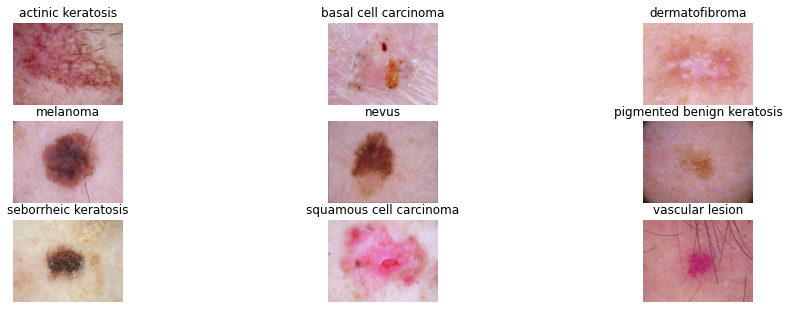

In [10]:
from os import listdir
from os.path import join
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
%matplotlib inline
image_indexes = [0]
selected_image_file_paths = dict()
for classification in class_names:
    image_directory = join(data_dir_train, classification)
    image_file_names = listdir(image_directory)
    selected_image_file_paths[classification] = [join(image_directory, image_file_names[i]) for i in image_indexes]

number_classes = len(class_names)
plt.figure(figsize=(16,16))    
for i,classification in enumerate(class_names):
    for j,image in enumerate(selected_image_file_paths[classification]):
        image_number = (i * len(image_indexes)) + j + 1
        ax = plt.subplot(number_classes,3,image_number)
        plt.title(classification)
        plt.axis("off")
        plt.imshow(mpimg.imread(image))



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
x_train_ds = train_ds
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here

color_mode = "rgb"
number_colour_layers = 3
image_size = (img_height, img_width)
image_shape = image_size + (number_colour_layers,)

preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape)
]

In [13]:
def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D()
    ]
core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)

In [14]:
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_classes)
]

In [15]:
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 77ms/step - loss: 2.1525 - accuracy: 0.2410 - val_loss: 2.2073 - val_accuracy: 0.0403
Epoch 2/20
56/56 [==============================] - 1s 19ms/step - loss: 1.6394 - accuracy: 0.4342 - val_loss: 1.8131 - val_accuracy: 0.2371
Epoch 3/20
56/56 [==============================] - 1s 18ms/step - loss: 1.3967 - accuracy: 0.4986 - val_loss: 1.6294 - val_accuracy: 0.3870
Epoch 4/20
56/56 [==============================] - 1s 18ms/step - loss: 1.3342 - accuracy: 0.5266 - val_loss: 1.2029 - val_accuracy: 0.6063
Epoch 5/20
56/56 [==============================] - 1s 18ms/step - loss: 1.2313 - accuracy: 0.5620 - val_loss: 1.3743 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 1s 18ms/step - loss: 1.1060 - accuracy: 0.6188 - val_loss: 1.4020 - val_accuracy: 0.4362
Epoch 7/20
56/56 [==============================] - 1s 18ms/step - loss: 1.0849 - accuracy: 0.6131 - val_loss: 1.2611 - val_accuracy: 0.5391
Epoch 8/20
5

### Visualizing training results

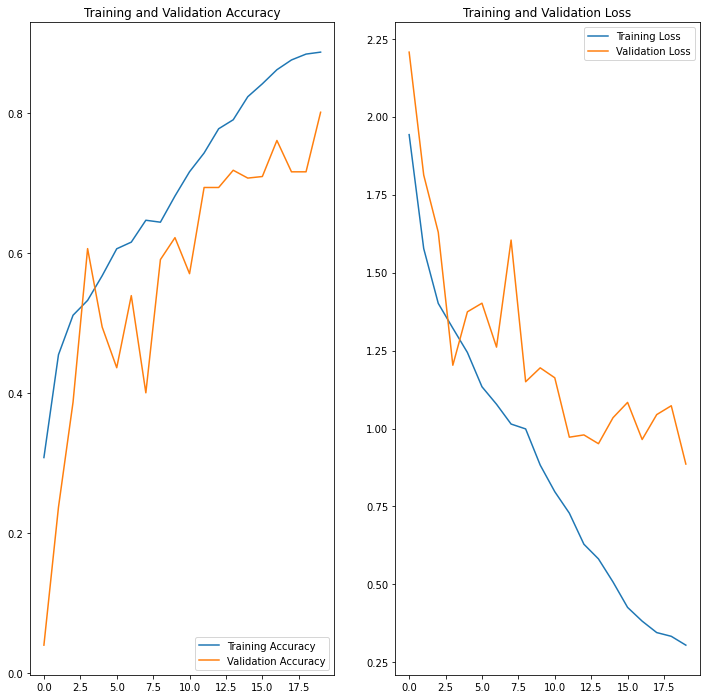

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

###Observation

At the end of 20 epochs , the model training has been completed and the training accuracy is very *high*.In general ,This is more likely due to careful control of the conditions in which the data was captured or some augmentation of the images rather than the model itself being particularly good, as it has not been **optimised**.


In [20]:
## Let's evaluate the model on the test data
history_test_model=model.evaluate(test_ds)

4/4 [==============================] - 4s 36ms/step - loss: 5.0954 - accuracy: 0.3220


In [21]:
## Model summary on the performance train, validation and test set
print('Model summary')
print('-----------------------------------------------------------------')
print('Train accuracy on epoch',epochs,'is',str(100*(acc[epochs-1]))+'%')
print('Validation accuracy on epoch',epochs,'is',str(100*(val_acc[epochs-1]))+'%')
print('Test accuracy: ', str(100*history_test_model[1])+'%')

Model summary
-----------------------------------------------------------------
Train accuracy on epoch 20 is 88.671875%
Validation accuracy on epoch 20 is 80.08948564529419%
Test accuracy:  32.20339119434357%


### Observation

The model performs well on the training data. However , the accuracy for the validation set has stopped improving from epoch 15 and similary the loss remains almost same since epoch 10 in the validation set. The model performs very poorly with the test set. We can conclude that the model is overfitting

### Write your findings here

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here


In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [24]:
def drop_out_layers(rate):
   return [tf.keras.layers.Dropout(rate)]

In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    drop_out_layers(0.4)+ \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    drop_out_layers(0.4)+ \
    conv_2d_pooling_layers(64, number_colour_layers) + \
    drop_out_layers(0.4)



dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(number_classes)
]

model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

### Compiling the model

In [26]:
## Your code goes here
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])


In [27]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 32)       

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 23ms/step - loss: 3.0313 - accuracy: 0.1453 - val_loss: 2.2545 - val_accuracy: 0.0000e+00
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0552 - accuracy: 0.2026 - val_loss: 2.3141 - val_accuracy: 0.0000e+00
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0057 - accuracy: 0.2267 - val_loss: 2.3583 - val_accuracy: 0.0268
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.9090 - accuracy: 0.3121 - val_loss: 2.4285 - val_accuracy: 0.0201
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.8095 - accuracy: 0.3285 - val_loss: 2.2324 - val_accuracy: 0.0425
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6927 - accuracy: 0.3806 - val_loss: 2.0930 - val_accuracy: 0.0962
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6263 - accuracy: 0.3978 - val_loss: 2.1187 - val_accuracy: 0.0805
Epoch

### Visualizing the results

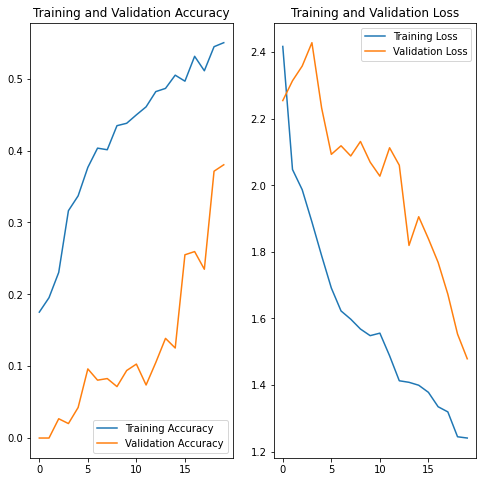

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
## Let's evaluate the model on the test data
history_test_model=model.evaluate(test_ds)

4/4 [==============================] - 4s 13ms/step - loss: 2.3756 - accuracy: 0.3220


In [31]:
## Model summary on the performance train, validation and test set
print('Model summary after adding the Dense layer')
print('-----------------------------------------------------------------')
print('Train accuracy on epoch',epochs,'is',str(100*(acc[epochs-1]))+'%')
print('Validation accuracy on epoch',epochs,'is',str(100*(val_acc[epochs-1]))+'%')
print('Test accuracy: ', str(100*history_test_model[1])+'%')

Model summary after adding the Dense layer
-----------------------------------------------------------------
Train accuracy on epoch 20 is 55.02232313156128%
Validation accuracy on epoch 20 is 38.03131878376007%
Test accuracy:  32.20339119434357%


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
## Your code goes here.

print(x_train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
path_to_training_dataset=str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+'/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F01EC180048>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F01EC0C4518>: 100%|██████████| 500/500 [00:18<00:00, 26.34 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F01F4167A58>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F01EC06BF98>: 100%|██████████| 500/500 [00:18<00:00, 27.49 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F01F45147B8>: 100%|██████████| 500/500 [00:18<00:00, 26.53 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=838x614 at 0x7F024008C400>: 100%|██████████| 500/500 [01:26<00:00,  5.81 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F01F5E682E8>: 100%|██████████| 500/500 [01:32<00:00,  5.41 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F01F438DF60>: 100%|██████████| 500/500 [00:18<00:00, 26.86 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F02561D4F28>: 100%|██████████| 500/500 [00:40<00:00, 12.35 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F01F44CEA90>:   0%|          | 1/500 [00:00<00:57,  8.66 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F01F5E3E828>: 100%|██████████| 500/500 [00:18<00:00, 27.14 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F025ECE6668>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F024008CCC0>: 100%|██████████| 500/500 [00:18<00:00, 27.11 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
from glob import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new=path_list
path_list

['/content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031823.jpg_849ef4c3-f8d8-4af7-bc6b-55f313ca24d1.jpg',
 '/content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_5046215d-6fc8-4827-b55b-30cc1337f800.jpg',
 '/content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_0ef94cf6-2d92-4f06-a7e3-a68cabece536.jpg',
 '/content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_d4b069c8-82d4-40b9-a1a7-aea2031489d0.jpg',
 '/content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboratio

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [46]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [48]:
original_df=pd.DataFrame()
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [49]:
new_df['Label'].value_counts()

seborrheic keratosis          500
dermatofibroma                500
actinic keratosis             500
nevus                         500
squamous cell carcinoma       500
vascular lesion               500
melanoma                      500
pigmented benign keratosis    500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [50]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [65]:
data_dir_train=pathlib.Path("/content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
               directory=data_dir_train, labels='inferred', label_mode='categorical', class_names=None,
               color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
               shuffle=True, seed=123, validation_split=.20, subset="training",
              interpolation='nearest', follow_links=False)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [66]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
               directory=data_dir_train, labels='inferred', label_mode='categorical', class_names=None,
               color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
               shuffle=True, seed=123, validation_split=.20, subset="validation",
              interpolation='nearest', follow_links=False)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [67]:
## your code goes here
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [68]:
## your code goes here

## Your code goes here
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])


In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 32)       

#### **Todo:**  Train your model

In [69]:
epochs = 50
## Your code goes here, use 50 epochs.
##epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 47s 271ms/step - loss: 1.5333 - accuracy: 0.4266 - val_loss: 1.4030 - val_accuracy: 0.4803
Epoch 2/50
169/169 [==============================] - 43s 247ms/step - loss: 1.3484 - accuracy: 0.4728 - val_loss: 1.3123 - val_accuracy: 0.5048
Epoch 3/50
169/169 [==============================] - 43s 248ms/step - loss: 1.3118 - accuracy: 0.4890 - val_loss: 1.2623 - val_accuracy: 0.5041
Epoch 4/50
169/169 [==============================] - 43s 246ms/step - loss: 1.2740 - accuracy: 0.5188 - val_loss: 1.1684 - val_accuracy: 0.5546
Epoch 5/50
169/169 [==============================] - 43s 249ms/step - loss: 1.1954 - accuracy: 0.5284 - val_loss: 1.1743 - val_accuracy: 0.5516
Epoch 6/50
169/169 [==============================] - 43s 246ms/step - loss: 1.1428 - accuracy: 0.5588 - val_loss: 1.2049 - val_accuracy: 0.5293
Epoch 7/50
169/169 [==============================] - 43s 247ms/step - loss: 1.1304 - accuracy: 0.5659 - val_loss: 1.0320 - val_ac

#### **Todo:**  Visualize the model results

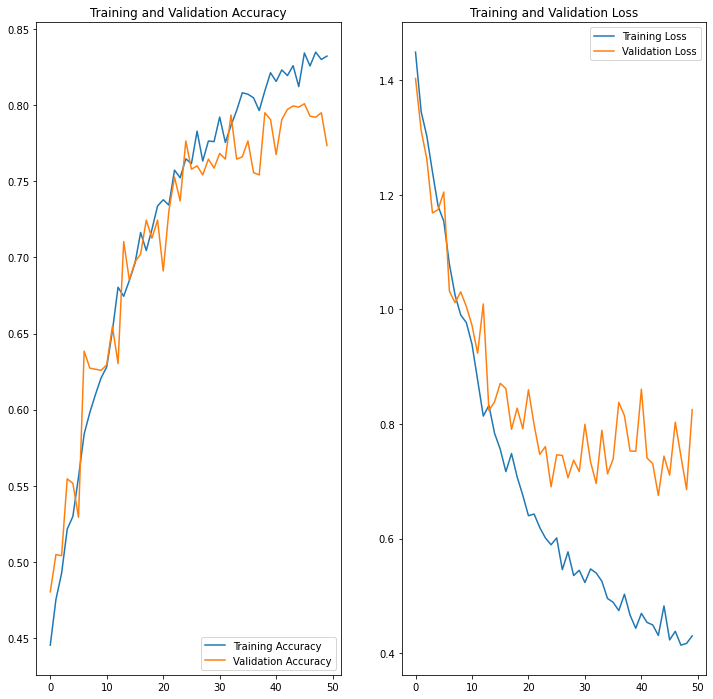

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [72]:
## Let's evaluate the model on the test data
history_test_model=model.evaluate(test_ds)

4/4 [==============================] - 4s 13ms/step - loss: 5.7008 - accuracy: 0.4237


In [73]:
## Model summary on the performance train, validation and test set
print('Model summary after class rebalance')
print('-----------------------------------------------------------------')
print('Train accuracy on epoch',epochs,'is',str(100*(acc[epochs-1]))+'%')
print('Validation accuracy on epoch',epochs,'is',str(100*(val_acc[epochs-1]))+'%')
print('Test accuracy: ', str(100*history_test_model[1])+'%')

Model summary after class rebalance
-----------------------------------------------------------------
Train accuracy on epoch 50 is 83.23442339897156%
Validation accuracy on epoch 50 is 77.35708951950073%
Test accuracy:  42.37288236618042%
